In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix
import pyopencl as cl
from time import time
from scipy.stats import skew # 3rd color moment

<h1><center>OpenCL</center></h1>

- [Tutorial](https://karthikhegde.blogspot.com/2013/09/hope-you-liked-previous-introductory.html)
- [Add time](http://benshope.blogspot.com/2013/11/pyopencl-tutorial-part-3-timing.html)

## Ver dispositivos OpenCL

In [2]:
print('\n' + '=' * 60 + '\nOpenCL Platforms and Devices')
for platform in cl.get_platforms():  # Print each platform on this computer
    print('=' * 60)
    print('Platform - Name:    ' + platform.name)
    print('Platform - Vendor:  ' + platform.vendor)
    print('Platform - Version: ' + platform.version)
    print('Platform - Profile: ' + platform.profile)
    for device in platform.get_devices():  # Print each device per-platform
        print('    ' + '-' * 56)
        print('    Device - Name:  ' + device.name)
        print('    Device - Type:  ' + cl.device_type.to_string(device.type))
        print('    Device - Max Clock Speed: {0} Mhz'.format(device.max_clock_frequency))
        print('    Device - Compute Units:   {0}'.format(device.max_compute_units))
        print('    Device - Local Memory:    {0:.0f} KB'.format(device.local_mem_size/1024))
        print('    Device - Constant Memory: {0:.0f} KB'.format(device.max_constant_buffer_size/1024))
        print('    Device - Global Memory:   {0:.0f} GB'.format(device.global_mem_size/1073741824.0))


OpenCL Platforms and Devices
Platform - Name:    Apple
Platform - Vendor:  Apple
Platform - Version: OpenCL 1.2 (Apr  7 2019 18:38:19)
Platform - Profile: FULL_PROFILE
    --------------------------------------------------------
    Device - Name:  Intel(R) Core(TM) i7-4770S CPU @ 3.10GHz
    Device - Type:  CPU
    Device - Max Clock Speed: 3100 Mhz
    Device - Compute Units:   8
    Device - Local Memory:    32 KB
    Device - Constant Memory: 64 KB
    Device - Global Memory:   16 GB
    --------------------------------------------------------
    Device - Name:  GeForce GT 750M
    Device - Type:  GPU
    Device - Max Clock Speed: 810 Mhz
    Device - Compute Units:   2
    Device - Local Memory:    48 KB
    Device - Constant Memory: 64 KB
    Device - Global Memory:   1 GB


## Seleccionar dispositivo y creación de contexto y cola de comandos

In [3]:
platform   = cl.get_platforms()[0]     # Apple iMac
cpu_device = platform.get_devices()[0] # Intel i7-4770S CPU @ 3.10GHz
gpu_device = platform.get_devices()[1] # Nvidia GeForce GT 750M

cntxt = cl.Context([gpu_device]) # Create a context in the device
queue = cl.CommandQueue(cntxt)   # Create a command queue

# [optional] property to get the time
#queue = cl.CommandQueue(cntxt, properties=cl.command_queue_properties.PROFILING_ENABLE)

<h1><center>Características de color</center></h1>

## Imagen RGB y su histograma

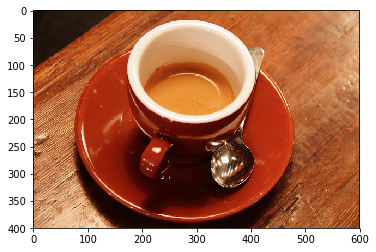

In [5]:
from skimage import data
img = data.coffee()
plt.imshow(img);

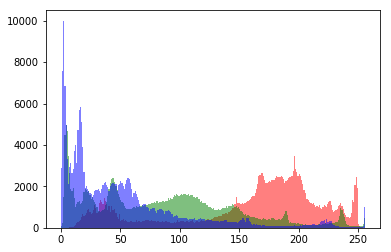

In [6]:
plt.hist(img[:,:,0].flatten(), 256, [0,256], color = 'r', alpha=0.5)
plt.hist(img[:,:,1].flatten(), 256, [0,256], color = 'g', alpha=0.5)
plt.hist(img[:,:,2].flatten(), 256, [0,256], color = 'b', alpha=0.5)
plt.show()

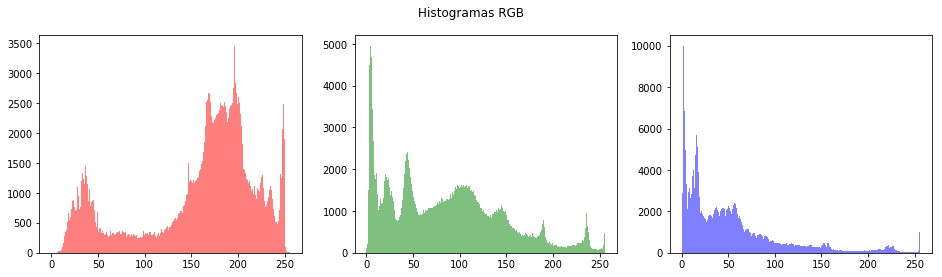

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))
fig.suptitle('Histogramas RGB')
axs[0].hist(img[:,:,0].flatten(), 256, [0,256], color='r', alpha=0.5)
axs[1].hist(img[:,:,1].flatten(), 256, [0,256], color='g', alpha=0.5)
axs[2].hist(img[:,:,2].flatten(), 256, [0,256], color='b', alpha=0.5)
plt.show()

# 1er, 2do y 3er momento de color

$$1er. mom. color = media_{canal} = \frac{1}{N}\sum_{i}^{N}Pixel_{canal}(i)$$

$$2do. mom. color = desv. típ._{canal} = \sqrt[2]{\frac{1}{N}\sum_{i}^{N}(Pixel_{canal}(i)-
Media_{canal})^2}$$

$$3er. mom. color = asimetría_{canal} = \sqrt[3]{\frac{1}{N}\sum_{i}^{N}(Pixel_{canal}(i)-Media_{canal})^3}$$

In [10]:
print("1er momento de color:")
print("\tMedia canal rojo: ", round(img[:,:,0].mean(), 2))
print("\tMedia canal verde:", round(img[:,:,1].mean(), 2))
print("\tMedia canal azul: ", round(img[:,:,2].mean(), 2))
print("")
print("2do momento de color:")
print("\tDesv. típica canal rojo: ", round(img[:,:,0].std(), 2))
print("\tDesv. típica canal verde:", round(img[:,:,1].std(), 2))
print("\tDesv. típica canal azul: ", round(img[:,:,2].std(), 2))
print("")
print("3er momento de color:")
print("\tAsimetría canal rojo: ", round(skew(img[:,:,0].flatten()), 2), "(negativo porque se concentra en la derecha)")
print("\tAsimetría canal verde:", round(skew(img[:,:,1].flatten()), 2), " (positivo porque se concentra en la izquierda)")
print("\tAsimetría canal azul: ", round(skew(img[:,:,2].flatten()), 2), " (muy positivo porque se concentra mucho en la izquierda)")

1er momento de color:
	Media canal rojo:  158.57
	Media canal verde: 85.79
	Media canal azul:  51.48

2do momento de color:
	Desv. típica canal rojo:  62.97
	Desv. típica canal verde: 60.96
	Desv. típica canal azul:  52.94

3er momento de color:
	Asimetría canal rojo:  -0.89 (negativo porque se concentra en la derecha)
	Asimetría canal verde: 0.58  (positivo porque se concentra en la izquierda)
	Asimetría canal azul:  1.65  (muy positivo porque se concentra mucho en la izquierda)


# 2do momento de color con OpenCL

El 1er momento (la media) no es paralelizable. Porque consiste en sumar los elementos de un array y dividir la suma por N.

In [33]:
np_r    = img[:,:,0].flatten().astype('float32') # array de float 32
np_g    = img[:,:,1].flatten().astype('float32') # array de float 32
np_b    = img[:,:,2].flatten().astype('float32') # array de float 32
np_out  = np.empty(np_r.shape, dtype=np.float32) # array de float 32
media_r = np_r.mean() # float 32
media_g = np_g.mean() # float 32
media_b = np_b.mean() # float 32

print("Longitud del array:", len(np_r))

Longitud del array: 240000


### 2do momento de color (desviación estándar) para el canal rojo con OpenCL

In [59]:
# Create the input and output buffers
mf = cl.mem_flags
cl_r   = cl.Buffer(cntxt, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=np_r)
cl_out = cl.Buffer(cntxt, mf.WRITE_ONLY, np_out.nbytes)

# Kernel Program
kernel = """
__kernel void std(__global float* canal, const float media, __global float* out) 
{
    int i = get_global_id(0);
    float resta = canal[i] - media;
    out[i]      = resta * resta;
}
"""

program = cl.Program(cntxt, kernel).build()                 # Build the Kernel
program.std(queue, np_r.shape, None, cl_r, media_r, cl_out) # Launch the Kernel
cl.enqueue_copy(queue, np_out, cl_out)                      # Copy back the results
print("Datos de salida (listos para hacer media y sqrt):\n", np_out)
print("\nDesv. típ. final (canal rojo): ", np.sqrt(np_out.mean()))

Datos de salida (listos para hacer media y sqrt):
 [1.8925246e+04 1.8925246e+04 1.9201385e+04 ... 3.2383075e-01 2.1225755e+02
 2.4239568e+02]

Desv. típ. final (canal rojo):  62.972866


### Comprobamos que funciona sin usar OpenCL

In [60]:
array_calculado_sin_opencl = (np_r - media_r)**2
dsv_tip_sin_opencl         = np.sqrt(array_calculado_sin_opencl.mean())

print("Datos de salida (listos para hacer media y sqrt):\n", array_calculado_sin_opencl)
print("\nDesv. típ. final (canal rojo)", dsv_tip_sin_opencl)

Datos de salida (listos para hacer media y sqrt):
 [1.8925246e+04 1.8925246e+04 1.9201385e+04 ... 3.2383075e-01 2.1225755e+02
 2.4239568e+02]

Desv. típ. final (canal rojo) 62.972866


# 3er momento de color con OpenCL

#### El 3er momento de color es la misma computación que el 2o momento de color pero elevando al cubo la resta, y haciendo la raíz cúbica al final.

<h1><center>Características de textura</center></h1>

## Create image

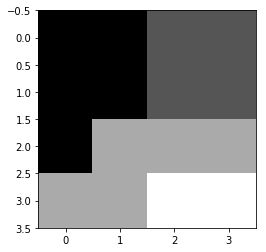

In [5]:
img = np.array([[0, 0, 1, 1],
                [0, 0, 1, 1],
                [0, 2, 2, 2],
                [2, 2, 3, 3]], dtype=np.uint8)

plt.imshow(img, cmap='gray', vmin=0, vmax=3)
plt.show()

## Generate GLCM

In [6]:
glcm = greycomatrix(image     = img,
                    distances = [1],
                    angles    = [0, np.pi/4, np.pi/2, 3*np.pi/4],
                    levels    = 4,
                    normed    = False)

glcm_angulo0   = glcm[:, :, 0, 0] # Ángulo 0
glcm_angulo45  = glcm[:, :, 0, 1] # Ángulo 45
glcm_angulo90  = glcm[:, :, 0, 2] # Ángulo 90
glcm_angulo135 = glcm[:, :, 0, 3] # Ángulo 135

In [7]:
glcm_angulo0

array([[2, 2, 1, 0],
       [0, 2, 0, 0],
       [0, 0, 3, 1],
       [0, 0, 0, 1]], dtype=uint32)

In [8]:
glcm_angulo45

array([[1, 1, 3, 0],
       [0, 1, 1, 0],
       [0, 0, 0, 2],
       [0, 0, 0, 0]], dtype=uint32)

In [9]:
glcm_angulo90

array([[3, 0, 2, 0],
       [0, 2, 2, 0],
       [0, 0, 1, 2],
       [0, 0, 0, 0]], dtype=uint32)

In [10]:
glcm_angulo135

array([[2, 0, 0, 0],
       [1, 1, 2, 0],
       [0, 0, 2, 1],
       [0, 0, 0, 0]], dtype=uint32)

# Segundo Momento Angular (ASM)

In [78]:
def asm(glcm):
    return np.sum(glcm**2)

asm(glcm_angulo0)

24

# Segundo Momento Angular (ASM) con OpenCL

In [81]:
# Numpy data
np_glcm = glcm_angulo0.flatten()                     # Convert the GLCM matrix to the input array
np_out  = np.empty(np_glcm.shape, dtype=np.uint32)   # Output array

# Create the input and output buffers
mf = cl.mem_flags
cl_glcm = cl.Buffer(cntxt, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=np_glcm)
cl_out  = cl.Buffer(cntxt, mf.WRITE_ONLY, np_out.nbytes)


# Kernel Program
kernel = """
__kernel void square(__global int* glcm, __global int* out) 
{
    int i = get_global_id(0);
    out[i] = glcm[i]*glcm[i];
}
"""

program = cl.Program(cntxt, kernel).build()                 # Build the Kernel
program.square(queue, np_glcm.shape, None, cl_glcm, cl_out) # Launch the Kernel
cl.enqueue_copy(queue, np_out, cl_out)                      # Copy back the results
print("Datos de salida (para sumar):", np_out)
print("Suma final: ", np_out.sum())

Datos de salida (para sumar): [4 4 1 0 0 4 0 0 0 0 9 1 0 0 0 1]
Suma final:  24


# Contraste

In [77]:
def contraste(glcm):
    sum = 0
    for i in range(0,4):
        for j in range(0,4):
            sum += (i-j)**2 * glcm[i,j]
    return sum
        
contraste(glcm_angulo0)

7

# Contraste con OpenCL

In [75]:
print("Datos de entrada:")
np_i = np.repeat(np.array([0,1,2,3], dtype=np.int32), 4); print("i:   ", np_i)
np_j = np.tile(  np.array([0,1,2,3], dtype=np.int32), 4); print("j:   ", np_j)
np_glcm = glcm_angulo0.flatten();                         print("GLCM:", G)

print("\nDatos de salida (basura de momento):")
np_out = np.empty(np_glcm.shape, dtype=np.int32); print("Out: ", np_out)

Datos de entrada:
i:    [0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
j:    [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]
GLCM: [2 2 1 0 0 2 0 0 0 0 3 1 0 0 0 1]

Datos de salida (basura de momento):
Out:  [2 2 1 0 0 2 0 0 0 0 3 1 0 0 0 1]


In [80]:
# Create the input and output buffers
mf = cl.mem_flags
cl_i    = cl.Buffer(cntxt, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=np_i)
cl_j    = cl.Buffer(cntxt, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=np_j)
cl_glcm = cl.Buffer(cntxt, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=np_glcm)
cl_out  = cl.Buffer(cntxt, mf.WRITE_ONLY, np_out.nbytes)


# Kernel Program
kernel = """
__kernel void square(__global int* i, __global int* j, __global int* glcm, __global int* out) 
{
    int idx = get_global_id(0);
    int resta = i[idx] - j[idx];
    out[idx]  = resta * resta * glcm[idx];
}
"""

program = cl.Program(cntxt, kernel).build()                 # Build the Kernel
program.square(queue, np_glcm.shape, None, cl_i, cl_j, cl_glcm, cl_out) # Launch the Kernel
cl.enqueue_copy(queue, np_out, cl_out)                      # Copy back the results
print("Datos de salida (para sumar):", np_out)
print("Suma final: ", np_out.sum())

Datos de salida (para sumar): [0 2 4 0 0 0 0 0 0 0 0 1 0 0 0 0]
Suma final:  7


# Correlación

# Correlación OpenCL

# Entropía

In [83]:
glcm_angulo0

array([[2, 2, 1, 0],
       [0, 2, 0, 0],
       [0, 0, 3, 1],
       [0, 0, 0, 1]], dtype=uint32)

In [82]:
def entropy(glcm):
    return np.log(glcm)

entropy(glcm_angulo0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


array([[0.69314718, 0.69314718, 0.        ,       -inf],
       [      -inf, 0.69314718,       -inf,       -inf],
       [      -inf,       -inf, 1.09861229, 0.        ],
       [      -inf,       -inf,       -inf, 0.        ]])

# Entropía con OpenCL